In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
data = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv', on_bad_lines='skip')

In [3]:
#Only include jobs that have been completed, 'STATE' = COMPLETED
#Exclude jobs with memory usage = 0 Mb
data = (data[
    (data['STATE']=='COMPLETED') & 
    (data['USEDMEM']!='0') &
    (data['USEDMEM']!='0.00M')
    ])

In [4]:
def str2seconds(timestr):
    if len(timestr) == 8:
        # split in hh, mm, ss
        hh, mm, ss = timestr.split(':')
        return int(hh) * 3600 + int(mm) * 60 + int(ss)
    else:
        d = timestr[0]
        dropday = timestr[2:]
        hh, mm, ss = dropday.split(':')
        return int(d) *3600*24 + int(hh) * 3600 + int(mm) * 60 + int(ss)

In [5]:
#First take times and convert to seconds
usedtime = data['USEDTIME']
reqtime = data['REQTIME']
usedtime_seconds = []
reqtime_seconds = []

for string in usedtime:
    usedtime_seconds.append(str2seconds(string))

for string in reqtime:
    reqtime_seconds.append(str2seconds(string))

In [6]:
data['USEDMEM'] = data['USEDMEM'].str.strip('M').astype(float)

In [7]:
data['req_time_seconds'] = reqtime_seconds
data['used_time_seconds'] = usedtime_seconds

#Get used memory per GPU for each job 
data['USEDMEM_per_GPU'] = data['USEDMEM']/data['GPUS']
#Weight the used memory based on amount of time the request was 
data['weighted_used_mem'] = (data['USEDMEM_per_GPU']*data['used_time_seconds'])/sum(usedtime_seconds)

In [8]:
#Group by partition name for seperate analysis if needed
turing = data[data['PARTITION'] == 'turing']
maxwell = data[data['PARTITION'] == 'maxwell']
pascal = data[data['PARTITION'] == 'pascal']

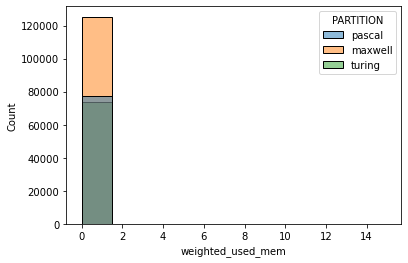

In [9]:
sns.histplot(x = data['weighted_used_mem'], hue = data['PARTITION'], bins = 10)
plt.show()

# Skewed Data 
This dataset is extremely skewed so lets set the axes to log scale. 

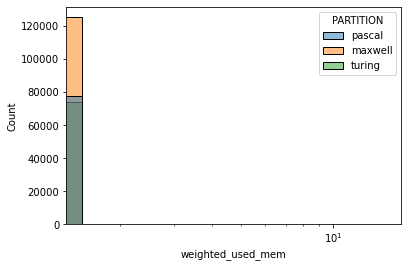

In [10]:
histogram = sns.histplot(x = data['weighted_used_mem'], hue = data['PARTITION'], bins = 10)
histogram.set(xscale='log')
plt.show()

We can see that that the histogram is still the same so lets look at the box plot and CDF represenatations of the data to get a closer picture of each of the partitions. 

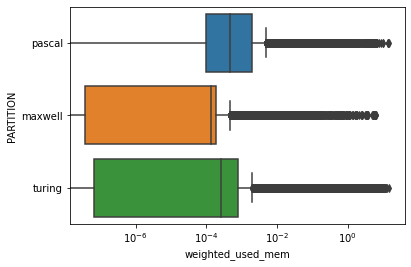

In [11]:
boxplot = sns.boxplot(x = data['weighted_used_mem'], y = data['PARTITION'])
boxplot.set(xscale= 'log')
plt.show()

In [12]:
data['weighted_used_mem'].groupby(data['PARTITION']).describe()

,count,mean,std,min,25%,50%,75%,max
PARTITION,,,,,,,,
maxwell,125370.0,0.002595,0.068776,0.0,3.721905e-08,0.000131,0.000186,6.152163
pascal,77769.0,0.018569,0.205759,0.0,1.008850e-04,0.000460,0.001988,14.197097
turing,74336.0,0.043253,0.412154,0.0,6.504556e-08,0.000263,0.000803,14.952076


We can see that each of the partitions have very simliar medians for amount of data used per GPU.   

In [13]:
#Lets look at the number of outliers for each of the partition distributions
df_quant = data.pivot(values=['weighted_used_mem'], columns=['PARTITION'])
Q1 = df_quant.quantile(0.25)
Q3 = df_quant.quantile(0.75)
IQR = Q3 - Q1

In [14]:
#Calculate the percentage of number of outliers to the total number of jobs in that distribution
outliers = ((df_quant < (Q1 - 1.5 * IQR)) | (df_quant > (Q3 + 1.5 * IQR))).sum()
print('The number of outliers for each of the partitions:\n', outliers)
percentage_outliers = outliers/[len(maxwell), len(pascal), len(turing)]
print('The percentage of outliers to total number of jobs per partition:\n', percentage_outliers)


The number of outliers for each of the partitions:
                    PARTITION
weighted_used_mem  maxwell      10946
                   pascal       17430
                   turing       14888
dtype: int64
The percentage of outliers to total number of jobs per partition:
                    PARTITION
weighted_used_mem  maxwell      0.087310
                   pascal       0.224125
                   turing       0.200280
dtype: float64


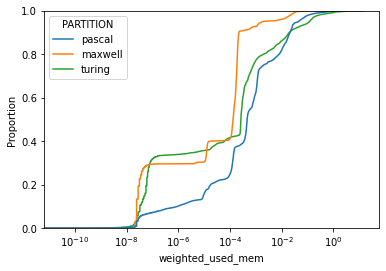

In [15]:
cdf_plot = sns.ecdfplot(x = data['weighted_used_mem'], hue = data['PARTITION'])
cdf_plot.set(xscale= 'log')
plt.show()

# Question 2 

In [16]:
data['weighted_num_GPUs'] = (data['GPUS']*data['used_time_seconds'])/sum(usedtime_seconds)

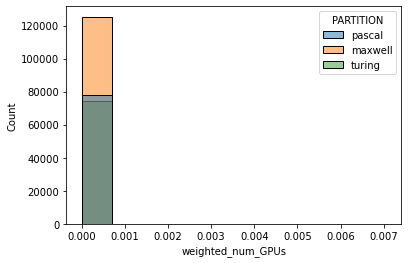

In [17]:
histogram_2 = sns.histplot(x = data['weighted_num_GPUs'], hue = data['PARTITION'], bins = 10)

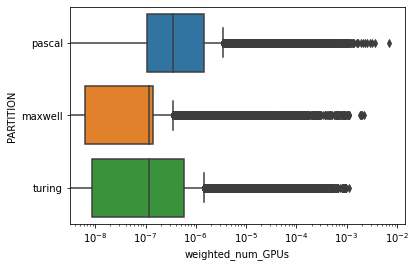

In [18]:
boxplot_2 = sns.boxplot(x = data['weighted_num_GPUs'], y = data['PARTITION'])
boxplot_2.set(xscale= 'log')
plt.show()

Proportion of jobs that used greater than 4 GPUS, aka an RoCE machine 

In [19]:
df_RoCE = data[data['GPUS']>4]

Proprtion for all jobs that have greater than 4 GPUs

In [20]:
prop_RoCE = len(df_RoCE)/len(data)
prop_RoCE

0.0031894765294170646

This is the breakdown of proportions of jobs that use the RoCE networking for each partition

In [21]:
df_RoCE.pivot(values = 'GPUS', columns= 'PARTITION').notna().sum()/[len(maxwell), len(pascal), len(turing)]

PARTITION
maxwell    0.002122
pascal     0.005696
turing     0.002368
dtype: float64

# Question 3 

In [22]:
data['gpu_runtime_total_seconds'] = data['GPUS']*data['used_time_seconds']

In [23]:
data.groupby('PARTITION')['gpu_runtime_total_seconds'].sum()/(365*24*60*60)

PARTITION
maxwell    10.504315
pascal     38.097031
turing     23.272118
Name: gpu_runtime_total_seconds, dtype: float64

# Question 4 

In [24]:
top_users = data.pivot(index = ['ACCOUNT','USER', 'JOBID'], columns = 'EXITCODE')
top_users.head()

USEDMEM     REQTIME  USEDTIME NODES CPUS GPUS  \
EXITCODE                     0:0         0:0       0:0   0:0  0:0  0:0   
ACCOUNT USER    JOBID                                                    
almonds annetta 39342056  166.81  1-00:00:00  00:05:26     1    5    1   
                39343810    5.41  2-00:00:00  00:00:16     1    5    1   
                39343811    5.41  2-00:00:00  00:00:09     1    5    1   
                39343851  161.09  2-00:00:00  00:03:28     1    5    1   
                39344173  185.50  2-00:00:00  01:49:13     1    5    1   

                         PARTITION      STATE req_time_seconds  \
EXITCODE                       0:0        0:0              0:0   
ACCOUNT USER    JOBID                                            
almonds annetta 39342056    turing  COMPLETED            86400   
                39343810    turing  COMPLETED           172800   
                39343811    turing  COMPLETED           172800   
                39343851    turing  COMPLETED           172800   
                39344173    turing  COMPLETED           172800   

                         used_time_seconds USEDMEM_per_GPU weighted_used_mem  \
EXITCODE                               0:0             0:0               0:0   
ACCOUNT USER    JOBID                                                          
almonds annetta 39342056               326          166.81      3.409660e-05   
                39343810                16            5.41      5.427360e-08   
                39343811                 9            5.41      3.052890e-08   
                39343851               208          161.09      2.100890e-05   
                39344173              6553          185.50      7.621764e-04   

                         weighted_num_GPUs gpu_runtime_total_seconds  
EXITCODE                               0:0                       0:0  
ACCOUNT USER    JOBID                                                 
almonds annetta 39342056      2.044038e-07                       326  
                39343810      1.003209e-08                        16  
                39343811      5.643050e-09                         9  
                39343851      1.304172e-07                       208  
                39344173      4.108767e-06                      6553

In [49]:
top_5 = top_users.groupby(level=[0,1]).size().nlargest(5)
top_5

ACCOUNT     USER   
glasshouse  marnie     140724
            margret     58839
            collins     13279
virginia    hillery      8404
malanga     arline       8110
dtype: int64

In [51]:
top_5.index

MultiIndex([('glasshouse',  'marnie'),
            ('glasshouse', 'margret'),
            ('glasshouse', 'collins'),
            (  'virginia', 'hillery'),
            (   'malanga',  'arline')],
           names=['ACCOUNT', 'USER'])

In [55]:
top_users.loc[top_5.index[0]:top_5.index[-1]]

USEDMEM     REQTIME  USEDTIME NODES CPUS GPUS  \
EXITCODE                       0:0         0:0       0:0   0:0  0:0  0:0   
ACCOUNT    USER   JOBID                                                    
glasshouse marnie 42185584  172.62  3-00:00:00  00:00:54     1    1    1   
                  42185585  174.79  3-00:00:00  00:00:55     1    1    1   
                  42185586  175.45  3-00:00:00  00:00:52     1    1    1   
                  42185669  221.04  3-00:00:00  12:15:55     1    1    1   
                  42185670  216.45  3-00:00:00  11:29:29     1    1    1   
...                            ...         ...       ...   ...  ...  ...   
malanga    arline 46752946   29.45  2-00:00:00  00:13:51     1    2    1   
                  46753073   30.19  2-00:00:00  00:15:04     1    2    1   
                  46753151   29.85  2-00:00:00  00:14:28     1    2    1   
                  46753169   28.11  2-00:00:00  00:14:16     1    2    1   
                  46753171   28.21  2-00:00:00  00:14:29     1    2    1   

                           PARTITION      STATE req_time_seconds  \
EXITCODE                         0:0        0:0              0:0   
ACCOUNT    USER   JOBID                                            
glasshouse marnie 42185584   maxwell  COMPLETED           259200   
                  42185585   maxwell  COMPLETED           259200   
                  42185586   maxwell  COMPLETED           259200   
                  42185669    turing  COMPLETED           259200   
                  42185670    turing  COMPLETED           259200   
...                              ...        ...              ...   
malanga    arline 46752946    pascal  COMPLETED           172800   
                  46753073    pascal  COMPLETED           172800   
                  46753151    pascal  COMPLETED           172800   
                  46753169    pascal  COMPLETED           172800   
                  46753171    pascal  COMPLETED           172800   

                           used_time_seconds USEDMEM_per_GPU  \
EXITCODE                                 0:0             0:0   
ACCOUNT    USER   JOBID                                        
glasshouse marnie 42185584                54          172.62   
                  42185585                55          174.79   
                  42185586                52          175.45   
                  42185669             44155          221.04   
                  42185670             41369          216.45   
...                                      ...             ...   
malanga    arline 46752946               831           29.45   
                  46753073               904           30.19   
                  46753151               868           29.85   
                  46753169               856           28.11   
                  46753171               869           28.21   

                           weighted_used_mem weighted_num_GPUs  \
EXITCODE                                 0:0               0:0   
ACCOUNT    USER   JOBID                                          
glasshouse marnie 42185584          0.000006      3.385830e-08   
                  42185585          0.000006      3.448531e-08   
                  42185586          0.000006      3.260429e-08   
                  42185669          0.006120      2.768543e-05   
                  42185670          0.005614      2.593859e-05   
...                                      ...               ...   
malanga    arline 46752946          0.000015      5.210416e-07   
                  46753073          0.000017      5.668130e-07   
                  46753151          0.000016      5.442408e-07   
                  46753169          0.000015      5.367168e-07   
                  46753171          0.000015      5.448678e-07   

                           gpu_runtime_total_seconds  
EXITCODE                                         0:0  
ACCOUNT    USER   JOBID                               
glasshouse marnie 4218